In [257]:
import json
import cv2
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import csv
import random
import hashlib
import numpy as np
import os

DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [258]:
file = open(DIR_PATH + "newspaper-navigator-master/beyond_words_data/beyond_words.txt", "r")

contents = file.read()
repo_dictionary = ast.literal_eval(contents)

file.close()

In [259]:
def gonito_transformer(metadata, directory_path):
    output = []
    
    path, dirs, files = next(os.walk(DIR_PATH+'scraped_photos/'))
    
    counter = 0
    for i in tqdm(range(len(metadata['data']))):
        baseline = metadata['data'][i]

        p = " ".join(baseline['location']['standard'].split('/')[-4:]).replace(' ', '_')
        
        if p not in files:
            print(f'File "{p}" not found in data')
            counter += 1
            files.append(p)
            continue

        baseline = baseline['region']

        p = p.split('.')[0]
        x0, y0 = baseline['x'], baseline['y']
        x1, y1 = baseline['x']+baseline['width'], baseline['y']+baseline['height']
        
        output.append(f'{p}/{x0},{y0},{x1},{y1}/{1}')
        
    print(f'files not found in data: {counter}')
    
    return output

In [260]:
gonito_output_6k = gonito_transformer(repo_dictionary, DIR_PATH)


files not found in data: 0


In [261]:
def show_random_img(output_list, directory_path):
    random_img = random.randint(0,len(output_list))
    variables = output_list[random_img].split('/')
    p = variables[0]
    coordinates = variables[1].split(',')
    x0, y0 = float(coordinates[0]), float(coordinates[1])
    x1, y1 = float(coordinates[2]), float(coordinates[3])

    box = cv2.rectangle(
        cv2.imread(directory_path+f'{p}.jpg'),
        (int(x0), int(y0)), 
        (int(x1), int(y1)), 
        (0, 255, 0), 
        thickness=10, 
    )

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(box, cmap='gray')

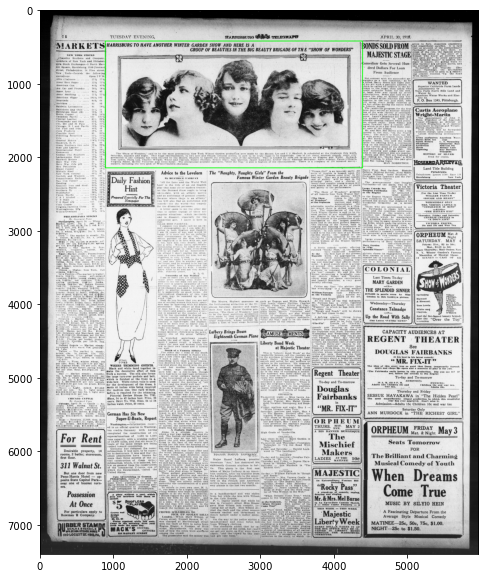

In [262]:
show_random_img(gonito_output_6k, DIR_PATH+'scraped_photos/')

In [263]:
for i in tqdm(range(len(gonito_output_6k))):
    name = gonito_output_6k[i].split('/')[0]
    hashnum = hashlib.md5(str(name).encode('Utf-8')).digest()[-1]
    
    old_path = f'{DIR_PATH}scraped_photos/{name}.jpg'
    new_path = f'{DIR_PATH}scraped_photos/{hashnum}_{name}.jpg'
    try: 
        os.rename(old_path, new_path)
    except:
        pass
    
    gonito_output_6k[i] = str(hashnum) + '_' + gonito_output_6k[i]

In [264]:
val = []
for i in tqdm(range(len(gonito_output_6k))):
    if int(gonito_output_6k[i].split('_')[0]) < 0.2 * 256:
        val.append(gonito_output_6k[i])

In [265]:
train = [x for x in gonito_output_6k if x not in val]

In [308]:
dev = []
for i in tqdm(range(len(train))):
    if int(train[i].split('_')[0]) < 0.26 * 256:
        dev.append(train[i])

In [312]:
train = [x for x in train if x not in dev]

In [321]:
sum = len(train)+len(dev)+len(val)

print(f'dev: {len(dev)/(sum)}')
print(f'val: {len(val)/(sum)}')
print(f'train: {len(train)/(sum)}')

dev: 0.06308307418924922
val: 0.20983266696283134
train: 0.7270842588479195


In [319]:
def save_file(output_file_name, output_list):
    with open(f'{output_file_name}.tsv', 'w', newline='') as f_output:
        tsv_output = csv.writer(f_output, delimiter='\t')
        tsv_output.writerow(output_list)

In [320]:
save_file('../data/gonito_format_train', train)
save_file('../data/gonito_format_val', val)
save_file('../data/gonito_format_dev', dev)